<a href="https://colab.research.google.com/github/parsakhavarinejad/unet_on_oxford_pet_dataset/blob/main/U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📔Import Libraries

In [2]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

## 🎊Model Training Configuration

In [49]:
batch_size = 16
lr = 1e-4
epochs = 15
height = 224
width = 224

## 📦 Loading the Oxford IIIT Pets dataset...

In [30]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

## 📂 Creating file paths for the model and callbacks

In [4]:
files_dir = os.path.join("files", "logs")
model_file = os.path.join(files_dir, "unet-model.h5")
# The model will be save inside its folder, but it is not available on github because of its size (almost 335mg)
log_file = os.path.join(files_dir, "log.csv")

In [32]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [33]:
create_dir(files_dir)

In [34]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

## 👥Data Preprocessing and Augmentation

In [35]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  global height, width
  input_image = tf.image.resize(datapoint['image'], (height, width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (height, width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [36]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [38]:
train_batches = (
    train_images
    .cache()
    .shuffle(1000)
    .batch(batch_size)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)

## 🐶Visualization

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


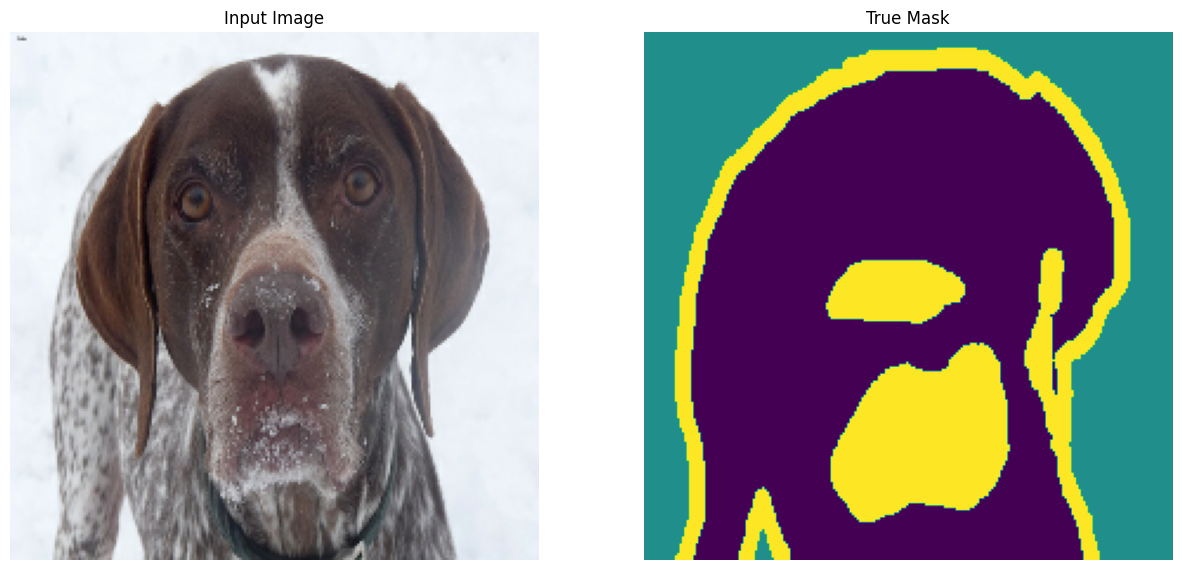

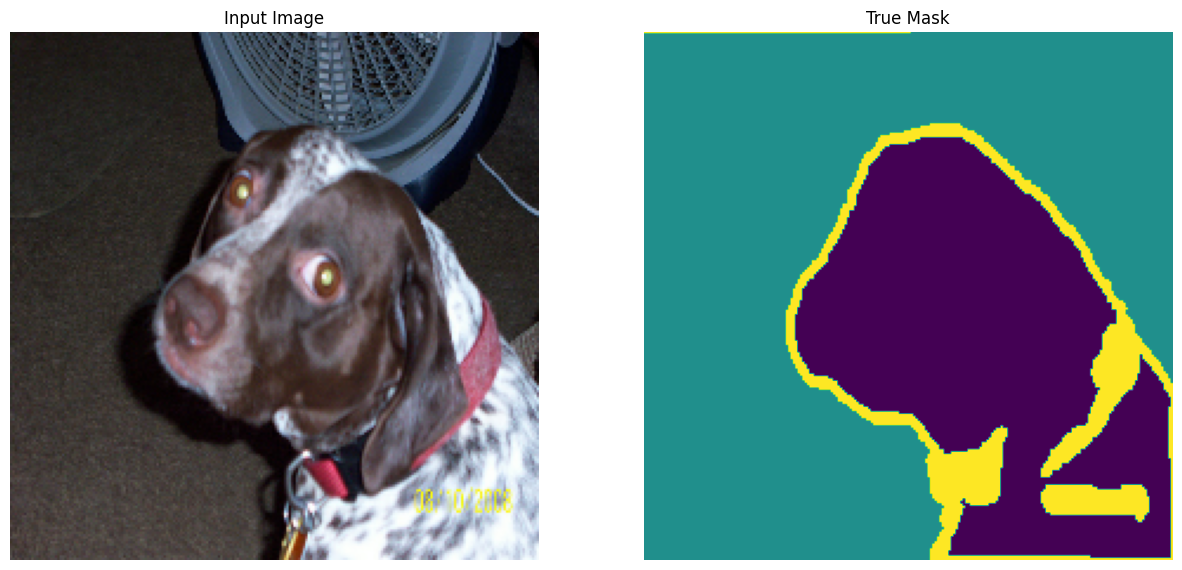

In [39]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [40]:
for x, y in train_batches:
  print(x.shape, y.shape)
  break

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(16, 224, 224, 3) (16, 224, 224, 1)


## 🌐Building a class for UNET model

In [41]:
class UNet:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_unet()

    def conv_block(self, inputs, num_filters):
        x = Conv2D(num_filters, 3, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        return x

    def encoder_block(self, inputs, num_filters):
        x = self.conv_block(inputs, num_filters)
        p = MaxPool2D((2, 2))(x)

        return x, p

    def decoder_block(self, inputs, skip, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)

        skip = tf.image.resize(skip, (x.shape[1], x.shape[2]))
        x = Concatenate()([x, skip])
        x = self.conv_block(x, num_filters)

        return x

    def build_unet(self):
        inputs = Input(shape=self.input_shape)

        s1, p1 = self.encoder_block(inputs, 64)
        s2, p2 = self.encoder_block(p1, 128)
        s3, p3 = self.encoder_block(p2, 256)
        s4, p4 = self.encoder_block(p3, 512)

        b1 = self.conv_block(p4, 1024)

        d1 = self.decoder_block(b1, s4, 512)
        d2 = self.decoder_block(d1, s3, 256)
        d3 = self.decoder_block(d2, s2, 128)
        d4 = self.decoder_block(d3, s1, 64)

        output = Conv2D(1, 1, padding='same', activation="sigmoid")(d4)
        model = Model(inputs, output, name='UNET')

        return model

    def compile_model(self, optimizer, loss, metrics):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def summary(self):
        self.model.summary()

    def fit(self, train_data, validation_data, epochs, callbacks):
        history = self.model.fit(train_data, epochs=epochs, validation_data=validation_data, callbacks=callbacks)
        return history

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def predict(self, data):
        return self.model.predict(data)


## 📈Compiling and fitting the model and a bit visual

In [42]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [43]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 224, 224, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=200, to_file='model.png')

In [46]:
model = UNet(input_shape)
opt = tf.keras.optimizers.Adam(lr)
model.compile_model(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [47]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [50]:
history = model.fit(train_batches,
          validation_data=test_batches,
          epochs=epochs,
          callbacks=callbacks)

Epoch 1/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


230/230 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.6885
Epoch 1: val_loss improved from inf to 0.42179, saving model to files/non.aug/unet-non-aug.h5
230/230 [==============================] - 124s 521ms/step - loss: 0.1972 - accuracy: 0.6885 - val_loss: 0.4218 - val_accuracy: 0.6011 - lr: 1.0000e-04
Epoch 2/15
230/230 [==============================] - ETA: 0s - loss: -0.3784 - accuracy: 0.7749
Epoch 2: val_loss improved from 0.42179 to -0.46834, saving model to files/non.aug/unet-non-aug.h5
230/230 [==============================] - 103s 449ms/step - loss: -0.3784 - accuracy: 0.7749 - val_loss: -0.4683 - val_accuracy: 0.7641 - lr: 1.0000e-04
Epoch 3/15
230/230 [==============================] - ETA: 0s - loss: -0.6932 - accuracy: 0.7930
Epoch 3: val_loss improved from -0.46834 to -1.01492, saving model to files/non.aug/unet-non-aug.h5
230/230 [==============================] - 103s 447ms/step - loss: -0.6932 - accuracy: 0.7930 - val_loss: -1.0149 - val_ac

## 📊Model evaluation

In [51]:
evaluate = model.evaluate(test_batches)
pre = model.predict(test_batches)

230/230 [==============================] - 25s 108ms/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


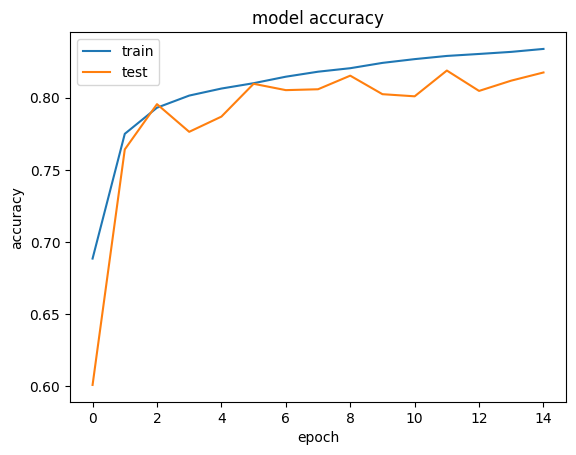

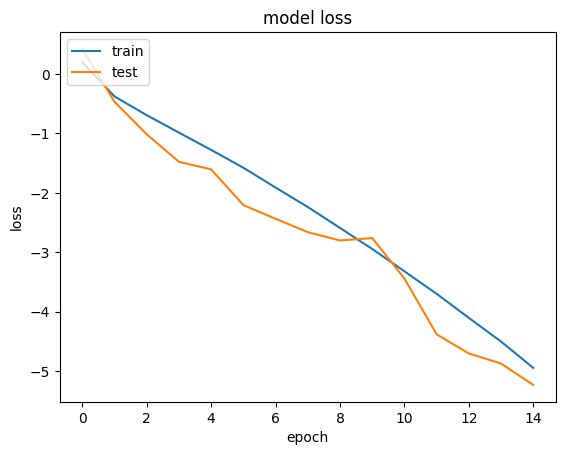

In [53]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()